# Datamining

# The Question: 

We are attempting to build a classification tree to determine how the budget, popularity, and average rating of a movie classify it as a "Flop", "Moderate", or "Hit". We will also include two more in-between categories called "controversial hit" (Makes money like a hit, but low user rating) and "beloved box office flop" (Highly rated, but box office flop).

The specific numbers to make each classification are included below under the section: "What is a success?"

In [ ]:
# get dependencies
%pip install pandas
%pip install numpy
%pip install seaborn
%pip install matplotlib
%pip install sklearn
%pip install scikit-learn
%pip install mysql.connector
%pip install sqlalchemy
%pip install mysql-connector-python sqlalchemy
%pip install mysqlclient
%pip install sklearn

In [92]:
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import mysql.connector as connection
from getpass import getpass
from sqlalchemy import create_engine, text
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn import tree
import matplotlib.pyplot as plt

# Step 2: Establish a connection to the MySQL database
Replace 'host' and 'database' with your actual details. We have allowed for dynamic input of username and secure password input.

In [93]:
user = input("Please enter your MySQL username: ")
password = getpass("Please enter your MySQL password: ")
host = "riku.shoshin.uwaterloo.ca"
database = 'db356_team61'

In [94]:
db_connection_str = f'mysql+mysqldb://{user}:{password}@{host}/{database}'
db_connection = create_engine(db_connection_str)

In [95]:
try:
    with db_connection.connect() as conn:
        print("MySQL connection successful ")
except Exception as e:
    print(f"error {e}")

MySQL connection successful 


# Load Data from database. 
We are mostly loading directly from the SQL tables we created, any csv code is strictly there for testing and working back when the servers were down.

In [96]:
try:
    with db_connection.connect() as connection:
   
        query_movie = text("SELECT movie_id, movie_revenue, popularity FROM Movie")
        result_movie = connection.execute(query_movie)
        movie_df = pd.DataFrame(result_movie.fetchall(), columns=result_movie.keys())
        df = pd.read_sql(query_movie, db_connection)
        csv_file_path = 'movie_data.csv'
        df.to_csv(csv_file_path, index=False)   
 
        query_movie_info = text("SELECT movie_id, budget FROM MovieInfo")
        result_movie_info = connection.execute(query_movie_info)
        movie_info_df = pd.DataFrame(result_movie_info.fetchall(), columns=result_movie_info.keys())

        # ef = pd.read_sql(query_movie_info, db_connection)
        # csv_file_path = 'movieinfo_data.csv'
        # ef.to_csv(csv_file_path, index=False) 

        query_extra_revenues = text("SELECT * FROM ExtraRevenues")
        result_extra_revenues = connection.execute(query_extra_revenues)
        extra_revenues_df = pd.DataFrame(result_extra_revenues.fetchall(), columns=result_extra_revenues.keys())

        ff = pd.read_sql(query_extra_revenues, db_connection)
        csv_file_path = 'revenues_data.csv'
        ff.to_csv(csv_file_path, index=False) 

    
        query_rating = text("SELECT rating, movie_id FROM Rating")
        result_rating = connection.execute(query_rating)
        ratings_df = pd.DataFrame(result_rating.fetchall(), columns=result_rating.keys())
        ratings_df['rating'] = ratings_df['rating'].astype(float)
        average_ratings_df = ratings_df.groupby('movie_id')['rating'].mean().reset_index()
        average_ratings_df.columns = ['movie_id', 'average_rating']
        merged_df = pd.merge(movie_df, average_ratings_df, on='movie_id', how='left')

        # gf = pd.read_sql(query_rating, db_connection)
        # csv_file_path = 'ratings_data.csv'
        # gf.to_csv(csv_file_path, index=False) 

        print("queries over")
        

except Exception as e:
    print(f"An error occurred: {e}")

queries over


# Merging Dataframes here

In [97]:
print(movie_df.columns)
print(extra_revenues_df.columns)
print(ratings_df.columns)

merged_df = pd.merge(merged_df, movie_info_df, on='movie_id')
merged_df = pd.merge(merged_df, extra_revenues_df, on='movie_id')

print(merged_df.columns)

Index(['movie_id', 'movie_revenue', 'popularity'], dtype='object')
Index(['movie_id', 'domestic_revenue', 'international_revenue',
       'worldwide_revenue'],
      dtype='object')
Index(['rating', 'movie_id'], dtype='object')
Index(['movie_id', 'movie_revenue', 'popularity', 'average_rating', 'budget',
       'domestic_revenue', 'international_revenue', 'worldwide_revenue'],
      dtype='object')


# What is Success?

In [98]:
def classify_our_success(row):
    if row['international_revenue']/row['budget'] < 1 and row['average_rating'] <= 3:
        return 'flop'
    elif row['international_revenue']/row['budget'] < 2:
        return 'moderate'
    elif row['international_revenue']/row['budget'] >= 2 and row['average_rating'] >= 3.8: 
        return 'hit'
    elif row['international_revenue']/row['budget'] < 1 and row['average_rating'] > 3:
        return 'beloved box office flop'
    else:
        return 'controversial hit'

merged_df['success'] = merged_df.apply(classify_our_success, axis=1)

In [99]:
# Drop NaN values
merged_df = merged_df.dropna(subset=['average_rating'])
print(merged_df)

       movie_id  movie_revenue     popularity  average_rating    budget  \
0     tt0099088      244527583  13.0439990000        2.809091  40000000   
2     tt0099348      424208848  11.6543490000        4.235294  22000000   
4     tt0099423      240031094  18.7859840000        3.451807  70000000   
7     tt0099653      505000000  11.9453970000        3.000000  22000000   
8     tt0099674      136766062  17.1853490000        3.750000  54000000   
...         ...            ...            ...             ...       ...   
2379  tt1524137       63100000  10.5950670000        2.750000  25000000   
2395  tt1547234       31083599   5.6547840000        3.000000  35000000   
2463  tt1637688      173930596  10.3246130000        4.040541  40000000   
2489  tt1667353      183018522  14.1701830000        4.500000  85000000   
2527  tt1758830       88058786  11.4188020000        3.781250  35000000   

      domestic_revenue  international_revenue  worldwide_revenue  \
0             40000000         

In [100]:
features = merged_df[['budget', 'popularity', 'average_rating']] 
target = merged_df['success']

# Let's train and create our classification tree

In [101]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [102]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

DecisionTreeClassifier()

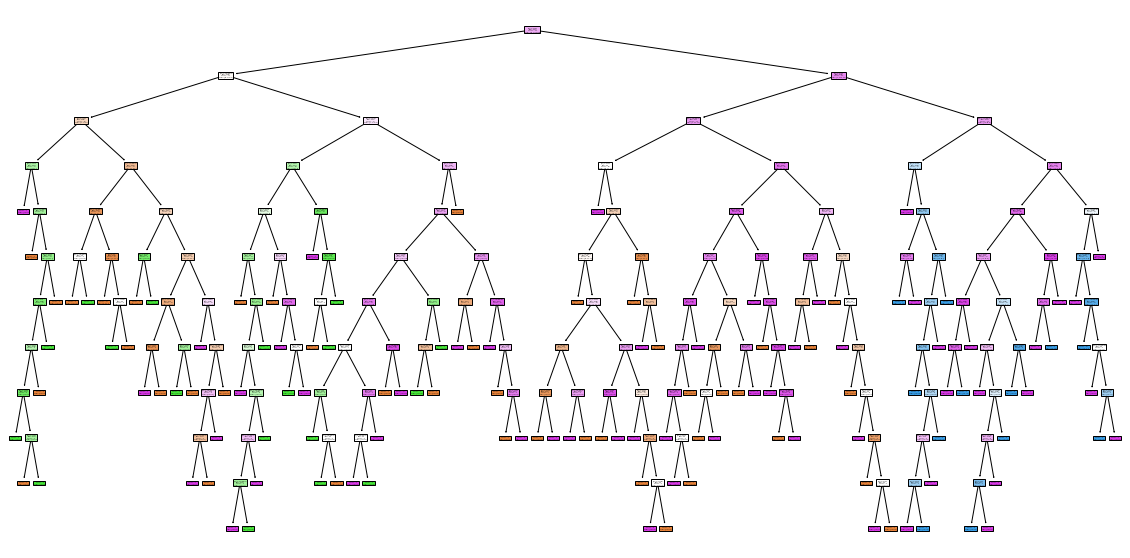

In [103]:
plt.figure(figsize=(20,10))
tree.plot_tree(clf, filled=True)
plt.show()

In [104]:
from sklearn.tree import export_text
feature_names = ['budget', 'popularity', 'average_rating']
tree = export_text(clf, feature_names=feature_names)
print(tree)

|--- average_rating <= 3.09
|   |--- budget <= 30500000.00
|   |   |--- popularity <= 7.37
|   |   |   |--- average_rating <= 1.97
|   |   |   |   |--- class: moderate
|   |   |   |--- average_rating >  1.97
|   |   |   |   |--- budget <= 3150000.00
|   |   |   |   |   |--- class: controversial hit
|   |   |   |   |--- budget >  3150000.00
|   |   |   |   |   |--- average_rating <= 3.04
|   |   |   |   |   |   |--- popularity <= 6.16
|   |   |   |   |   |   |   |--- popularity <= 5.33
|   |   |   |   |   |   |   |   |--- popularity <= 4.00
|   |   |   |   |   |   |   |   |   |--- class: flop
|   |   |   |   |   |   |   |   |--- popularity >  4.00
|   |   |   |   |   |   |   |   |   |--- popularity <= 4.48
|   |   |   |   |   |   |   |   |   |   |--- class: controversial hit
|   |   |   |   |   |   |   |   |   |--- popularity >  4.48
|   |   |   |   |   |   |   |   |   |   |--- class: flop
|   |   |   |   |   |   |   |--- popularity >  5.33
|   |   |   |   |   |   |   |   |--- class: co